In [1]:
import os
import sys
import numpy as np
import string
import pickle
import xarray as xr
import cartopy
import cmocean
import datetime
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
matplotlib.rc_file('../rc_file_paper')
%load_ext autoreload
%autoreload 2
%aimport - numpy - scipy - matplotlib.pyplot

In [3]:
sys.path.append("..")
from maps import rect_polygon
from tqdm import notebook
from paths import path_samoc, path_results, path_prace
from paths import file_ex_ocn_ctrl, file_ex_ocn_lc1, file_RMASK_ocn, file_RMASK_ocn_low
from regions import SST_index_bounds
from filters import lowpass, bandpass
from constants import spy, A_earth
from scipy.stats import binned_statistic
from xr_regression import xr_quadtrend
from matplotlib.ticker import NullFormatter
from bb_analysis_timeseries import AnalyzeTimeSeries as ATS
from arch.bootstrap import StationaryBootstrap, optimal_block_length

The file "/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/run/spinup_pd_maxcores_f09_g16.cam2.h0.0001-01.nc" does not exist


color conventions:
- global black
- Atlantic blue
- Pacific orange
- Southern red

In [4]:
spy = 365*24*3600

# bandpass std

had  AMV:  0.112
had  AMV:  0.105
72
0.10124436611724973

ctrl AMV:  0.043
ctrl AMV:  0.048
65
0.04640634007779543

lc1  AMV:  0.043
lc1  AMV:  0.034
58
0.033519353912706676

had  PDO:  0.385
had  PDO:  0.327
53
0.31730034560483766

ctrl PDO:  0.358
ctrl PDO:  0.274
61
0.27302173552439996

lc1  PDO:  0.316
lc1  PDO:  0.272
55
0.2673193772420404

had  SOM:  0.073
had  SOM:  0.131
74
0.12371544294338299

ctrl SOM:  0.117
ctrl SOM:  0.115
61
0.11298989868508218

lc1  SOM:  0.083
lc1  SOM:  0.067
30
0.06634569728732206



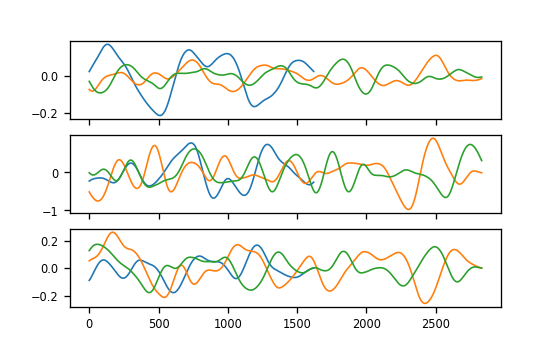

In [7]:
f, ax = plt.subplots(3,1, sharex=True)
for j, idx in enumerate(['AMV', 'PDO', 'SOM']):
    for i, run in enumerate(['had', 'ctrl', 'lc1']):
        if run=='ctrl':   ts, times = '_51_301' , np.arange(  51, 301,1/12)+1/12
        elif run=='lc1':  ts, times = '_11_261' , np.arange(  11, 261,1/12)+1/12
        elif run=='had':  ts, times = ''        , np.arange(1870,2019,1/12)+1/12
        c = ['C0', 'C1','C3'][j]
        if idx in ['AMV', 'SOM']:
            if idx=='AMV':    fn = f'{path_prace}/SST/AMO_ds_dt_raw_{run}{ts}.nc'
            elif idx=='SOM':  fn = f'{path_prace}/SST/{idx}_ds_dt_raw_{run}{ts}.nc'
            da = xr.open_dataarray(fn, decode_times=False)
        elif idx=='PDO':
            fn = f'{path_prace}/SST/PMV_EOF_20N_{run}{ts}.nc'
            da = xr.open_dataset(fn, decode_times=False).pcs.isel(mode=0).squeeze()
        print(f'{run:4} {idx}:  {bandpass(da, 12*10, 12*50)[7*12:-7*12].std().values:.3f}')
        print(f'{run:4} {idx}:  {lowpass(da, 12*13).std().values:.3f}')
        ax[j].plot(bandpass(da, 12*10, 12*50)[7*12:-7*12])
        
        n = int(optimal_block_length(da.values)['stationary'].values)
        print(n)
#         bs = StationaryBootstrap(12*150, lowpass(da,12*13).values)
        bs = StationaryBootstrap(n, lowpass(da,12*13).values)
        print(bs.apply(np.std, 100).mean())
        print('')
        

In [8]:
int(optimal_block_length(da.values)['stationary'].values)

30

### bootstrapping

In [9]:


def func(x, stat='mean'):
    if stat=='mean':
        return x.mean(axis=0)
    elif stat=='var':
        return x.var(axis=0)

y = np.random.randn(100000, 2)
bs = IIDBootstrap(y)
variances = bs.var(func, 1000, extra_kwargs={'stat': 'var'})

NameError: name 'IIDBootstrap' is not defined

In [10]:
variances

NameError: name 'variances' is not defined

# spectra means/slopes in MV/IV band
data from `SST_indices.ipynb`; multitaper spectra of raw SST indices (i.e. not filtered)

In [5]:
def band_integral(spec, monthly=True):
    """ integrates between 10 and 50 years periods
    input:
    spec  .. tuple with spectrum, frequency
    output:
    p  .. power in [10,50] year range
    rp .. relative power [10,50]/[1,10]
    """
    if monthly: f = 12
    else:       f = 1
    lf_band = np.logical_and(spec[1]*f>1/50 , spec[1]*f<=1/10)
    hf_band = np.logical_and(spec[1]*f>1/10 , spec[1]*f<=1/2)
    fi_band = np.logical_and(spec[1]*f>1/150, spec[1]*f<=1/10) # similar to 13 year lowpass filter
    df = spec[1][1] - spec[1][0]    
    lf_power = df*np.sum(lf_band*spec[0])
    hf_power = df*np.sum(hf_band*spec[0])
    fi_power = df*np.sum(fi_band*spec[0])
    to_power = df*np.sum(spec[0])
    
    edges = np.logspace(np.log10(1/50),np.log10(1/2),num=17)
    bs = binned_statistic(spec[1]*f,spec[0]/f, bins=edges)
    mv_mean, iv_mean = np.mean(np.split(bs[0], 2), axis=1)
    
    centers = np.logspace(np.log10(1/50),np.log10(1/2),num=33)[1::2]
    x, _ = np.split(centers, 2)
    y, _ = np.split(bs[0], 2)
    slope, intercept = np.polyfit(np.log10(x), np.log10(y), deg=1)
    mv_exp, mv_factor = slope, 10**intercept  # plot as plt.plot(edges[:9], mv_factor*(x)**mv_exp); x=edges[:9]
    return to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor

#### index spectra

In [11]:
# calculate spectra and put them into dictionary
fn = f'{path_results}/MV-paper/idx_spectra.pkl'
if os.path.exists(fn):
    spec_dict_unfilt = pickle.load(open(fn, 'rb'))
else:
    spec_dict_unfilt = {}
    ft = 'lowpass'
    for i, run in enumerate(['had', 'ctrl', 'lc1']):
        if run=='ctrl':   ts = '_51_301' 
        elif run=='lc1':  ts = '_11_261' 
        elif run=='had':  ts = ''
        for j, idx in notebook.tqdm(enumerate(['AMO', 'SOM', 'TPI', 'PMV_EOF_20N', 'PMV_EOF_Eq', 'PMV_EOF_38S'])):
            if idx in ['AMO','SOM','TPI']: dt = '_ds_dt_raw'
            else:                          dt = ''
            fc = 12*13
            fn = f'{path_prace}/SST/{idx}{dt}_{run}{ts}.nc'
            assert os.path.exists(fn), f'{fn} does not exist'
            if idx in ['AMO', 'SOM', 'TPI']:  da = xr.open_dataarray(fn, decode_times=False)
            else:                             da = xr.open_dataset(fn, decode_times=False).pcs.isel(mode=0).squeeze()
            da = da.isel(time=slice(0,int(250*12)))
    #         assert len(da) in [12*149, 12*150, 12*250]
            spec_dict_unfilt[f'{idx}_{run}_spec'] = ATS(da).spectrum()
            spec_dict_unfilt[f'{idx}_{run}_rnnh'] = ATS(da).mc_ar1_spectrum(N=10000)  # red noise spectrum
#     pickle.dump(spec_dict_unfilt, open(fn, 'wb'))

In [14]:
spec_dict_unfilt['AMO_ctrl_spec']

(array([1.23987283e-01, 5.50068445e-01, 1.16418771e+00, ...,
        1.46693391e-03, 4.50804224e-04, 3.99580591e-04]),
 array([0.00000000e+00, 3.33333333e-04, 6.66666667e-04, ...,
        4.99333333e-01, 4.99666667e-01, 5.00000000e-01]),
 array([[3.22529901e-02, 4.76633215e-01],
        [3.34227863e-01, 9.05296439e-01],
        [1.07400728e+00, 1.26194026e+00],
        ...,
        [1.11826246e-03, 1.92432027e-03],
        [2.06795418e-04, 9.82731872e-04],
        [5.26132558e-05, 3.03468482e-03]]))

In [13]:
for j, idx in enumerate(['AMO', 'PMV_EOF_20N', 'SOM']):
    for i, run in enumerate(['had', 'ersst', 'cobe', 'ctrl', 'lc1']):
        spec = spec_dict_unfilt[f'{idx}_{run}_spec']
        to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral(spec)
        print(f'{run:7} {idx[:3]}   {to_power:.3f}   {fi_power:.3f} {lf_power:.2f}   {hf_power:.2f} {hf_power/(hf_power+lf_power):.2f}   '+\
              f'{mv_mean:.2f} {iv_mean:.2f}   {mv_mean/iv_mean:.2f} {np.sqrt(mv_mean)/(np.sqrt(iv_mean)):.2f}   {mv_exp:.2f}')
    print('')

had     AMO   0.041   0.016 0.01   0.01 0.56   0.16 0.04   4.13 2.03   -1.94
ersst   AMO   0.057   0.026 0.02   0.02 0.52   0.23 0.05   4.74 2.18   -1.40
cobe    AMO   0.042   0.020 0.01   0.01 0.49   0.19 0.03   5.57 2.36   -1.57
ctrl    AMO   0.019   0.005 0.00   0.01 0.72   0.04 0.02   1.74 1.32   -0.25
lc1     AMO   0.029   0.005 0.00   0.02 0.78   0.06 0.05   1.18 1.08   -0.26

had     PMV   1.000   0.270 0.22   0.38 0.63   3.23 1.15   2.80 1.67   -0.88
ersst   PMV   1.000   0.289 0.25   0.38 0.60   3.67 1.15   3.20 1.79   -0.91
cobe    PMV   1.000   0.287 0.24   0.39 0.62   3.58 1.19   3.01 1.73   -0.95
ctrl    PMV   1.000   0.340 0.31   0.38 0.55   4.03 1.30   3.09 1.76   -0.24
lc1     PMV   1.000   0.340 0.31   0.46 0.60   3.72 1.37   2.71 1.65   0.29

had     SOM   0.079   0.023 0.01   0.02 0.55   0.18 0.04   4.03 2.01   -0.93
ersst   SOM   0.299   0.076 0.06   0.06 0.48   0.94 0.17   5.64 2.37   -0.98
cobe    SOM   0.102   0.039 0.03   0.02 0.41   0.36 0.05   7.02 2.65   -0.7

In [166]:
def mean_power(A):
    std = 10**((np.log10(A[2][:,1]/12)-np.log10(A[2][:,0]/12))/4)
    f_MV = (A[1]*12>1/50)*(A[1]*12<=1/10)
    f_IV = (A[1]*12>1/10)*(A[1]*12<=1/2 )
    w_MV = np.log(A[1][1:])*f_MV[1:]
    w_IV = np.log(A[1][1:])*f_IV[1:]
    mu_MV = np.average(A[0][1:]/12, weights=w_MV)
    mu_IV = np.average(A[0][1:]/12, weights=w_IV)
    sd_MV = np.sqrt( np.sum(w_MV*np.log10(std[1:])**2*f_MV[1:]) / np.sum(w_MV))# * (np.sum(f_MV))/(np.sum(f_MV)-1) )
    sd_IV = np.sqrt( np.sum(w_IV*np.log10(std[1:])**2*f_IV[1:]) / np.sum(w_IV))# * (np.sum(f_IV))/(np.sum(f_IV)-1) )
    return std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV

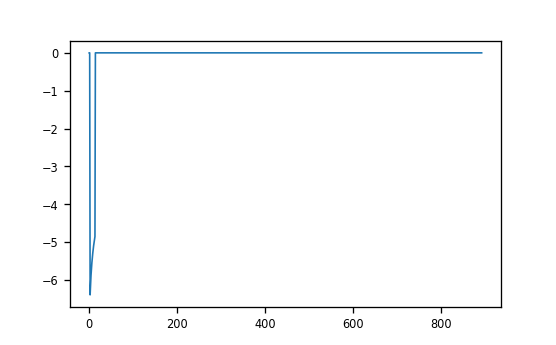

In [188]:
plt.plot(np.log(A[1][1:])*f_MV[1:])

0.13358068946160692
0.03356392959299811
0.32200267811547945


(0.001, 10.0)

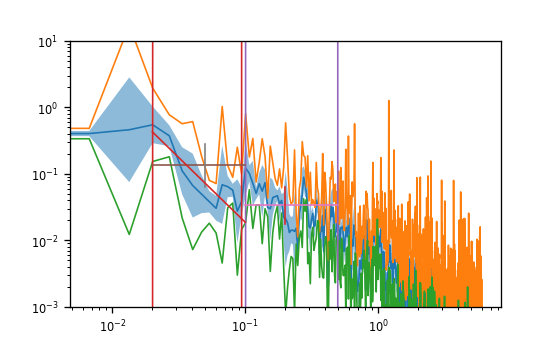

In [194]:
A = spec_dict_unfilt['AMO_had_spec']
std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power(A)
plt.fill_between(A[1]*12, A[0]/12*std, A[0]/12/std, alpha=.5)
plt.plot(A[1]*12, A[0]     /12)
plt.plot(A[1]*12, A[2][:,1]/12)
plt.plot(A[1]*12, A[2][:,0]/12)

plt.plot(A[1]*12, 10*f_MV)
plt.plot(A[1]*12, 10*f_IV)


plt.plot([1/50,1/10], 2*[mu_MV])
plt.plot([1/10,1/2 ], 2*[mu_IV])
print(mu_MV)
print(mu_IV)

print(sd_MV)
plt.loglog()
plt.plot(2*[1/20], [mu_MV/10**sd_MV, mu_MV*10**sd_MV])
plt.plot(2*[1/5], [mu_IV/10**sd_IV, mu_IV*10**sd_IV], c='C3')

to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral(A)
edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
plt.plot(edges, mv_factor*(edges)**mv_exp, c='C3')
plt.ylim((1e-3,1e1))


In [251]:
def calc_slope(A):
    f_MV = (A[1]*12>1/50)*(A[1]*12<=1/10)
    x = np.delete(A[1]*12, np.where(f_MV==False))
    y = np.delete(A[0]/12, np.where(f_MV==False))

    weights = -np.log(x)
    X = sm.add_constant(np.log10(x))
    wm = sm.WLS(np.log10(y), X, weights=weights)
    r = wm.fit()
    offset = r.params[0]
    slope = r.params[1]
    slope_SE = r.bse[1]
    return offset, slope, slope_SE


for idx in ['AMO', 'PMV_EOF_20N', 'SOM']:
    plt.figure()
    for run in ['ctrl','lc1']:
        offset, slope, slope_SE = calc_slope(spec_dict_unfilt[f'{idx}_{run}_spec'])
        
        
        if run=='ctrl':   offset1, slope1, slope_SE1 = offset, slope, slope_SE
        elif run=='lc1':  offset2, slope2, slope_SE2 = offset, slope, slope_SE

#         plt.plot(X[:,1], np.log10(y))

    n = sum(f_MV)
    z = abs(slope1-slope2)/np.sqrt(slope_SE1*slope_SE2)
    print(slope1, slope_SE1, slope2, slope_SE2, z)
#     plt.plot(X[:,1], r1.params[0]+r1.params[1]*X[:,1])
#     plt.plot(X[:,1], r2.params[0]+r2.params[1]*X[:,1])


-0.27066527723782696 0.37678918586746685 0.053489002667615304 0.29875893182045293 0.966144523000486
-0.45392195949717234 0.373989314281891 -0.06310610090930535 0.3210022254798704 1.1279466527928774
-0.4442962862859919 0.24868113189341148 -0.2930754240949606 0.22647763369680313 0.6372027373171949


<Figure size 556.96x345.74 with 0 Axes>

<Figure size 556.96x345.74 with 0 Axes>

<Figure size 556.96x345.74 with 0 Axes>

In [247]:
weights

array([3.72970145, 3.57555077, 3.44201938, 3.32423634, 3.21887582,
       3.12356565, 3.03655427, 2.95651156, 2.88240359, 2.81341072,
       2.7488722 , 2.68824757, 2.63108916, 2.57702194, 2.52572864,
       2.47693848, 2.43041846, 2.3859667 , 2.34340709, 2.30258509])

In [235]:
r1.bse

array([0.09782901, 0.0417544 ])

In [224]:
r1.summary()

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:762: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     38.57
Date:                Mon, 17 May 2021   Prob (F-statistic):           6.84e-10
Time:                        16:58:40   Log-Likelihood:                   -inf
No. Observations:                1500   AIC:                               inf
Df Residuals:                    1498   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1192      0.098    -21.662      0.000      -2.311      -1.927
x1            -0.2593      0.042     -6.210      0.000      -0.341      -0.177
==============================================================================
Omnibus:                     1508.599   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1752721.519
Skew:                          -3.702   Prob(JB):                         0.00
Kurtosis:                     170.298   Cond. No.                         35.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
r2.params

array([-1.02123394,  0.11186364])

In [225]:
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.008
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.52
Date:                Mon, 17 May 2021   Prob (F-statistic):           0.000705
Time:                        16:58:40   Log-Likelihood:                   -inf
No. Observations:                1500   AIC:                               inf
Df Residuals:                    1498   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0212      0.077    -13.227      0.000      -1.173      -0.870
x1             0.1119      0.033      3.395      0.001       0.047       0.177
==============================================================================
Omnibus:                     2108.918   Durbin-Watson:                   0.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4143725.948
Skew:                          -7.095   Prob(JB):                         0.00
Kurtosis:                     260.096   Cond. No.                         35.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [211]:
b1, b2 = r1.params[1], r2.params[1]
c1 = 

t_value = ((slope - (null_hypothesis))/results.bse) #bse = standard error
p_value = stats.t.sf(t_value, results.df_resid) #calculate p-value from t-statistic lookup tables

Type:            RegressionResultsWrapper
String form:     <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x2b431a764d10>
File:            ~/.conda/envs/CESM/lib/python3.7/site-packages/statsmodels/regression/linear_model.py
Docstring:      
This class summarizes the fit of a linear regression model.

It handles the output of contrasts, estimates of covariance, etc.

Parameters
----------
model : RegressionModel
    The regression model instance.
params : ndarray
    The estimated parameters.
normalized_cov_params : ndarray
    The normalized covariance parameters.
scale : float
    The estimated scale of the residuals.
cov_type : str
    The covariance estimator used in the results.
cov_kwds : dict
    Additional keywords used in the covariance specification.
use_t : bool
    Flag indicating to use the Student's t in inference.
**kwargs
    Additional keyword arguments used to initialize the results.

Attributes
----------
pinv_wexog
    See model class docstr

In [208]:
(np.array([np.log10(A[0][1:]/12),np.log10(A[0][1:]/12)])).shape

(2, 894)

In [181]:
Y = [1,3,4,5,2,3,4]
X = range(1,8)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(range(1,8)))
results = wls_model.fit()
results.params

array([2.91666667, 0.0952381 ])

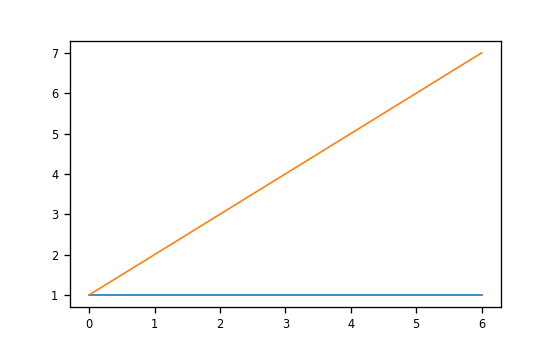

In [182]:
plt.plot(X)

-3.380938570454262 -1.7419794380117686 0.30603051058936476
-1.9430744530638224 0.00021412709728635542
-0.8475725215472034 -0.9517089412627614 0.22389219201838892
-0.8845727608771098 0.18486321393396724
-2.072798604775013 -0.9261603384400932 0.16689834770546902
-0.92625266084534 0.008539795575309901
-1.8539582741482836 -0.27066527723782696 0.37678918586746685
-0.2452221631593902 0.017460594637213823
-0.07678549513356439 -0.45392195949717234 0.373989314281891
-0.24195074855926868 1.6718756822098673
-1.2888376290481196 -0.4442962862859919 0.24868113189341148
-0.479499994462663 0.0464490111250165
-1.2168826349118995 0.053489002667615304 0.29875893182045293
-0.2588416814994411 0.023624607576088755
0.4344090882273486 -0.06310610090930535 0.3210022254798704
0.28890996623282106 8.298373187729663
-1.3057261188554408 -0.2930754240949606 0.22647763369680313
-0.3343313413012399 0.04356251624663753


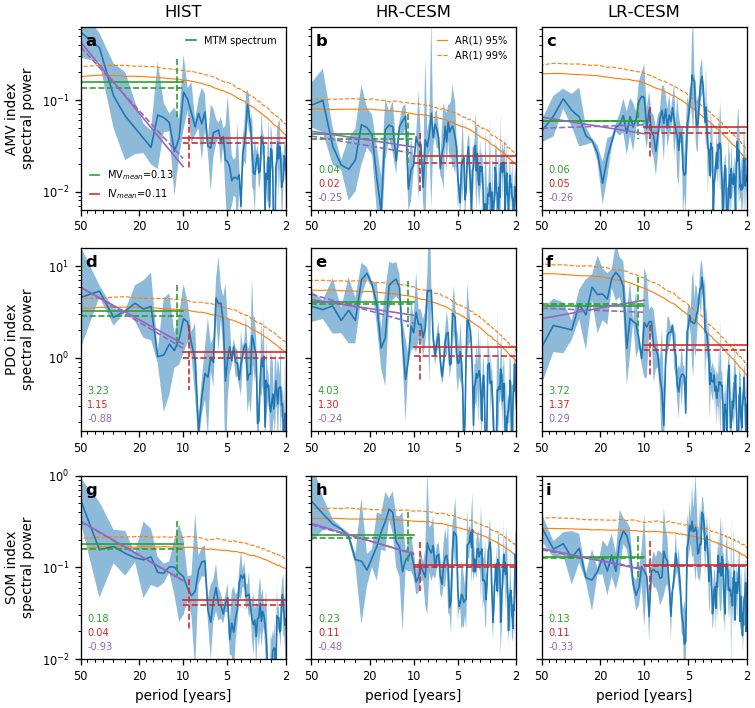

In [269]:
# spectra
xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
f, ax = plt.subplots(3, 3, figsize=(6.4,6), sharey='row', constrained_layout=True)
for i, run in enumerate(['had', 'ctrl', 'lc1']):
    for j, idx in enumerate(['AMO', 'PMV_EOF_20N', 'SOM']):
        factor = 12
        spec = spec_dict_unfilt[f'{idx}_{run}_spec']
        std, f_MV, f_IV, w_MV, w_IV, mu_MV, mu_IV, sd_MV, sd_IV = mean_power(spec)
        offset, slope, slope_SE = calc_slope(spec)
        print(offset, slope, slope_SE)
        rnnh = spec_dict_unfilt[f'{idx}_{run}_rnnh']
        ax[j,i].set_xscale('log', basex=10)
        ax[j,i].set_yscale('log', basey=10)
        ax[j,i].set_xlim((1/50,1/2))
        power = [-0.2,1.2,0][j]
        ax[j,i].set_ylim(top=10**(power), bottom=10**(power-2))
        # l50, = ax[j,i].plot(rnnh['freq']*factor, rnnh['median']/factor, c='C1', label='AR(1) 50%')
        l95, = ax[j,i].plot(rnnh['freq']*factor, rnnh['95']/factor, c='C1', ls='-' , lw=.7, label='AR(1) 95%')
        l99, = ax[j,i].plot(rnnh['freq']*factor, rnnh['99']/factor, c='C1', ls='--', lw=.7, label='AR(1) 99%')
        ax[j,i].fill_between(spec[1]*12, spec[0]/12*std, spec[0]/12/std, alpha=.5)
        
        lmt, = ax[j,i].plot(spec[1]     *factor, spec[0]   /factor, c='C0', label='MTM spectrum')
        ax[j,0].set_ylabel(f'{["AMV", "PDO", "SOM"][j]} index\nspectral power')
        ax[j,i].xaxis.set_minor_locator(locmin)
        ax[j,i].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax[j,i].set_xticks([1/x for x in xticks])
        ax[j,i].set_xticklabels(xticks)
        ax[j,i].text(.02,.96, string.ascii_lowercase[3*j+i], transform=ax[j,i].transAxes, va='top', ha='left', weight='bold')

        to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral(spec)
        print(mv_exp, mv_factor)
#         print(f'{run:4} {idx:13}   mu_MV = {mv_mean:.3f}, mu_IV = {iv_mean:.3f}, slope_MV = {mv_exp:.3f}')
        mv, = ax[j,i].plot([1/50,1/10], 2*[mv_mean], c='C2', label=f'MV$_{{mean}}$={mv_mean:.2f}')
        iv, = ax[j,i].plot([1/10,1/2 ], 2*[iv_mean], c='C3', label=f'IV$_{{mean}}$={iv_mean:.2f}')
        
        ax[j,i].plot([1/50,1/10], 2*[mu_MV], c='C2', ls='--')
        ax[j,i].plot([1/10,1/2 ], 2*[mu_IV], c='C3', ls='--')
        ax[j,i].plot(2*[1/10/1.1], [mu_MV*10**sd_MV, mu_MV/10**sd_MV], c='C2', ls='--')
        ax[j,i].plot(2*[1/10*1.1], [mu_IV*10**sd_IV, mu_IV/10**sd_IV], c='C3', ls='--')
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
#         ax[j,i].plot(edges, offset*(edges)**slope, c='C4', ls='--',label=f'MV$_{{exp}}$={mv_exp:.2f}')
        ax[j,i].plot(edges, 10**offset*edges**slope, ls='--',c='C4')
        slope, = ax[j,i].plot(edges, mv_factor*(edges)**mv_exp, c='C4', label=f'MV$_{{exp}}$={mv_exp:.2f}')
        if i!=0 or j!=0:
            ax[j,i].text(1/45, 10**(power-1.6), f'{mv_mean:.2f}', color='C2', fontsize=6)
            ax[j,i].text(1/45, 10**(power-1.75), f'{iv_mean:.2f}', color='C3', fontsize=6)
            ax[j,i].text(1/45, 10**(power-1.9), f'{mv_exp:.2f}' , color='C4', fontsize=6)
    ax[0,i].title.set_text(['HIST', 'HR-CESM', 'LR-CESM'][i])
    ax[-1,i].set_xlabel('period [years]')
l0 = ax[0,0].legend(handles=[mv, iv], loc=3, fontsize=6, frameon=False, handlelength=1)
# l0 = ax[0,0].legend(handles=[mv, iv, slope], loc=3, fontsize=6, frameon=False, handlelength=1)
l1 = ax[0,0].legend(handles=[lmt], loc=1, fontsize=6, frameon=False, handlelength=1)
l2 = ax[0,1].legend(handles=[l95, l99], loc=1, fontsize=6, frameon=False, handlelength=1)
ax[0,0].add_artist(l0)
f.align_ylabels()
# plt.savefig(f'{path_results}/MV-paper/index_mtm')
# plt.savefig(f'{path_results}/MV-paper/Fig4.eps')
# plt.savefig(f'{path_results}/compare_spectra/indices.eps')

[]

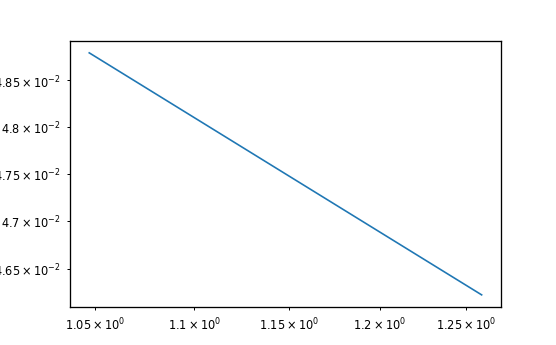

In [259]:
plt.plot(10**edges, 10**(offset + edges*slope))
plt.loglog()

#### SHF

In [ ]:
SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

In [ ]:
f, ax = plt.subplots(1,2,figsize=(6.4,4), gridspec_kw={'width_ratios':[10,1]}, sharey=True, constrained_layout=True)
# ax.text(.01,.98, 'c', transform=ax.transAxes, va='top', ha='left', weight='bold')        
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        
        offset, slope, slope_SE = calc_slope(spec)
        shift= [1,1/10,1/5000,1/20000][j]
        l, = ax[0].plot(freq, spec*shift,
                      label=f'{basin} Ocean',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = ax[0].plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  ax[0].arrow(1/41+(1/40.3-1/41)*(2-j), spec[6], 0, -(spec[6]-spec[6]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)
                
        to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral((spec, freq, jackknife), monthly=False)
        mv, = ax[1].plot([0,.5], 2*[mv_mean*shift], c=c, ls=ls, label=f'MV$_{{mean}}$={mv_mean:.2f}')
        iv, = ax[1].plot([.5,1], 2*[iv_mean*shift], c=c, ls=ls, label=f'IV$_{{mean}}$={iv_mean:.2f}')
        
        edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
        slope_, = ax[0].plot(edges, mv_factor*(edges)**mv_exp*shift, c='C4', ls=ls, label=f'MV$_{{exp}}$={mv_exp:.2f}')
        ax[0].plot(edges, 10**offset*edges**slope, ls='--',c='C4')
#         if i!=0 or j!=0:
#             ax[1].text(0, 1e-1, f'{mv_mean:.2f}', color=c, fontsize=6)
#             ax[1].text(0, 1e-2, f'{iv_mean:.2f}', color=c, fontsize=6)
#             ax[0].text(1/75, 1e-1, f'{mv_exp:.2f}' , color='C4', fontsize=6)
        
        
l1 = ax[0].legend(handles=h_, bbox_to_anchor=(0.5, 0.93), loc='center', frameon=True, ncol=2, fontsize=8)
ax[0].add_artist(l1)
l2 = ax[0].legend(handles=h, bbox_to_anchor=(0.5, 1.06), loc='center', ncol=4, fontsize=8)

ax[0].set_xlim(1/100,1/2)
ax[0].set_xlabel(r'period [year]')
ax[0].set_ylabel(r'SHF spectral power  [ZJ$^2$/year]')
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
ax[0].set_yscale('log', basey=10)
ax[0].set_xscale('log', basex=10)
ax[0].xaxis.set_minor_locator(locmin)
ax[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].set_xticks([1/x for x in xticks])
ax[0].set_xticklabels(xticks)
ax[0].set_ylim((2e-5,1e3))

ax[1].set_xticks([.25,.75])
ax[1].set_xticklabels(['MV','IV'])
plt.savefig(f'{path_results}/compare_spectra/SHF.eps')

#### GMST

In [12]:
gmst_had  = xr.open_dataarray(f'{path_prace}/GMST/GMST_dt_yrly_had.nc', decode_times=False)
gmst_had  = gmst_had.isel({'time':slice(9,158)})
gmst_ctrl = xr.open_dataset(f'{path_prace}/GMST/GMST_ctrl.nc').GMST.isel({'time':slice(50,300)})
gmst_ctrl['time'] = (gmst_ctrl.time/365).astype(dtype=int)
gmst_ctrl -= xr_quadtrend(gmst_ctrl)
gmst_lc1_ = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lc1.nc', decode_times=False)
gmst_lc1  = gmst_lc1_.rolling(time=12).mean().isel(time=slice(11,-1,12)).isel({'time':slice(10,260)})
gmst_lc1['time'] = (gmst_lc1.time/365).astype(dtype=int)
gmst_lc1 -= xr_quadtrend(gmst_lc1)

TOA_ctrl = xr.open_dataarray(f'{path_prace}/TOA/TOM_ctrl.nc', decode_times=False).isel(time=slice(50,300))
TOA_lc1  = xr.open_dataarray(f'{path_prace}/TOA/TOM_lc1.nc' , decode_times=False).isel(time=slice(10,260))

# SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False).isel(time=slice(10,260))
# SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


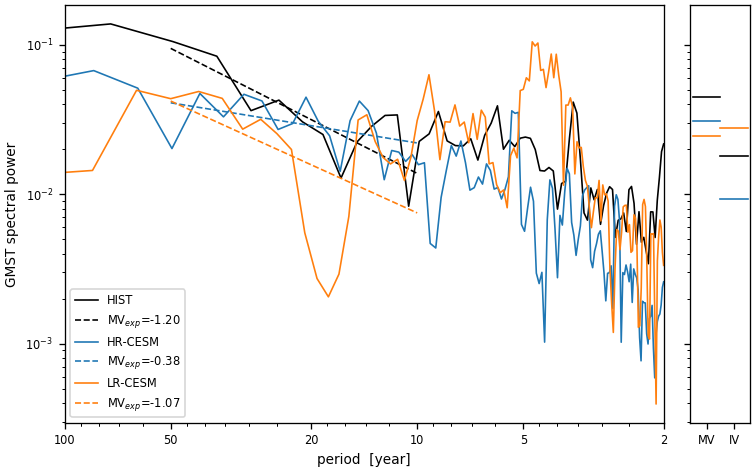

In [13]:
f, ax = plt.subplots(1,2,figsize=(6.4,4), gridspec_kw={'width_ratios':[10,1]}, sharey=True, constrained_layout=True)
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    c = ['k', 'C0', 'C1'][i]
    ls = '-'#[':','-','--'][i]
    (spec, freq, jackknife) = ATS(gmst).spectrum()
    offset, slope, slope_SE = calc_slope(spec)
    l, = ax[0].plot(freq, spec, label=['HIST','HR-CESM','LR-CESM'][i], c=c, ls=ls)
    
    to_power, fi_power, lf_power, hf_power, mv_mean, iv_mean, mv_exp, mv_factor = band_integral((spec, freq, jackknife), monthly=False)
    mv, = ax[1].plot([0,.5], 2*[mv_mean], c=c, ls=ls, label=f'MV$_{{mean}}$={mv_mean:.2f}')
    iv, = ax[1].plot([.5,1], 2*[iv_mean], c=c, ls=ls, label=f'IV$_{{mean}}$={iv_mean:.2f}')

    edges = np.logspace(np.log10(1/50),np.log10(1/10),num=9)
    ax[j,i].plot(edges, 10**offset*edges**slope, ls='--',c='C4')
    slope_, = ax[0].plot(edges, mv_factor*(edges)**mv_exp, c=c, ls='--', label=f'MV$_{{exp}}$={mv_exp:.2f}')
    
ax[0].legend(fontsize=7, loc='lower left')
ax[0].set_xlabel('period  [year]')
ax[0].set_ylabel(r'GMST spectral power')
ax[0].set_xlim(1/100,1/2)
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
ax[0].set_yscale('log', basey=10)
ax[0].set_xscale('log', basex=10)
ax[0].xaxis.set_minor_locator(locmin)
ax[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax[0].set_xticks([1/x for x in xticks])
ax[0].set_xticklabels(xticks)

ax[1].set_xticks([.25,.75])
ax[1].set_xticklabels(['MV','IV'])
plt.savefig(f'{path_results}/compare_spectra/GMST.eps')

# Coherence spectra

In [14]:
np.log10(1/2)

-0.3010299956639812

### integration over multidecadal band (10-50 years period) 

In [15]:
freq = spec[1]
freq.shape

()

BinnedStatisticResult(statistic=array([8.16958526e-05,            nan]), bin_edges=array([0.02, 0.1 , 0.5 ]), binnumber=array([1]))
BinnedStatisticResult(statistic=array([           nan,            nan,            nan, 8.16958526e-05,
                  nan,            nan,            nan,            nan]), bin_edges=array([0.02      , 0.02990698, 0.04472136, 0.06687403, 0.1       ,
       0.14953488, 0.2236068 , 0.33437015, 0.5       ]), binnumber=array([4]))
BinnedStatisticResult(statistic=array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan, 8.16958526e-05,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan]), bin_edges=array([0.02      , 0.02445689, 0.02990698, 0.03657158, 0.04472136,
       0.05468727, 0.06687403, 0.08177654, 0.1       , 0.12228445,
       0.14953488, 0.18285791, 0.2236068 , 0.27343635, 0.33437015,
       

LinAlgError: SVD did not converge in Linear Least Squares

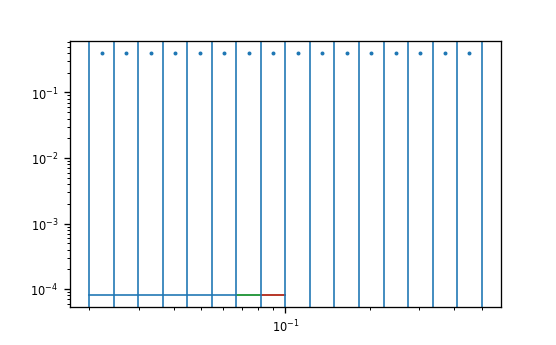

In [16]:
edges = np.logspace(np.log10(1/50),np.log10(1/2),num=3)
bs = binned_statistic(spec[1]*12,spec[0]/12, bins=edges)
print(bs)
# for edge in bs[1]:    plt.axvline(edge)
plt.step(edges,np.concatenate([bs[0][:1],bs[0]]), zorder=1)
plt.loglog(spec[1]*12, spec[0]/12, zorder=0)
# plt.semilogx(spec[1]*12, spec[0]/12, zorder=0)

edges = np.logspace(np.log10(1/50),np.log10(1/2),num=9)
bs = binned_statistic(spec[1]*12,spec[0]/12, bins=edges)
print(bs)
# for edge in bs[1]:    plt.axvline(edge)
plt.step(edges,np.concatenate([bs[0][:1],bs[0]]), zorder=1)

edges = np.logspace(np.log10(1/50),np.log10(1/2),num=17)
bs = binned_statistic(spec[1]*12,spec[0]/12, bins=edges)
print(bs)
for edge in bs[1]:     plt.axvline(edge)
plt.step(edges,np.concatenate([bs[0][:1],bs[0]]), zorder=1)


centers = np.logspace(np.log10(1/50),np.log10(1/2),num=33)[1::2]
x, _ = np.split(centers, 2)
y, _ = np.split(bs[0], 2)
plt.scatter(centers, [0.4]*len(centers), s=2)
slope, intercept = np.polyfit(np.log10(x), np.log10(y), deg=1)
print(slope, intercept)
plt.plot(edges[:9], 10**intercept*(edges[:9])**slope)

plt.ylim((1e-2,None))
plt.xlim((1/100,1/1))

In [ ]:
10**edges[:9]

In [ ]:
0.25*np.log(5)

In [ ]:
0.2*np.log(10)

In [ ]:
print(np.mean([0.09095701,
       0.13157014, 0.14584873, 0.0609053]))
print(np.mean([0.07954852, 0.10073571,
       0.07574703, 0.17622863, 0.22703506, 0.07548725, 0.07276664,
       0.05110679]))

In [ ]:
h, l = np.mean(np.split(np.array([0.07954852, 0.10073571, 0.07574703, 0.17622863, 0.22703506, 0.07548725, 0.07276664, 0.05110679]),2), axis=1)

In [ ]:
h

In [ ]:
l

In [ ]:
type(spec)

In [ ]:
print(f'{band_integral(spec):(.2f,.2f,.2f,.2f)}')

# Fig. 5: SHF spectra

In [17]:
SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False).isel(time=slice(50,300))
SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False).isel(time=slice(10,260))

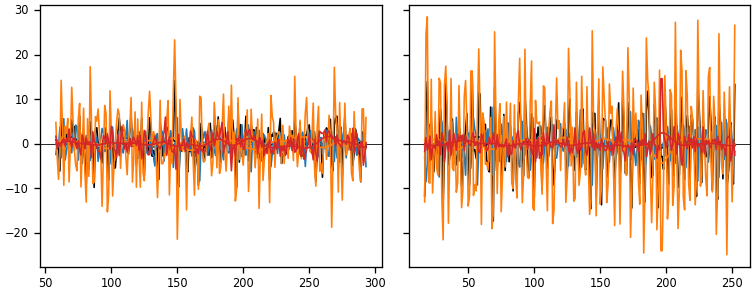

In [18]:
f, ax = plt.subplots(1,2,figsize=(6.4,2.5), sharey=True, constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ax[i].axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21, 13)
        ax[i].plot(ts.time[7:-7]/365, ts_[7:-7], c=c)
        ax[i].plot(ts.time[7:-7]/365, ts__[7:-7], c=c)
# ax[1].set_xlim((190,210))

In [19]:
SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

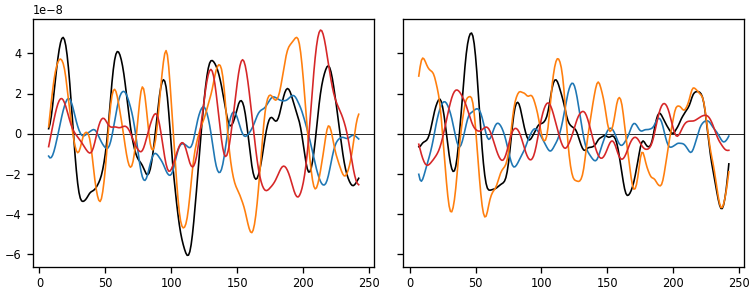

In [20]:
f, ax = plt.subplots(1,2,figsize=(6.4,2.5), sharey=True, constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ax[i].axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21, 13)
        ax[i].plot(ts.time[7:-7], ts_[7:-7], c=c)
        # ax[i].plot(ts.time[7:-7]/365, ts__[7:-7], c=c)
# ax[1].set_xlim((190,210))

(1e-05, 1000.0)

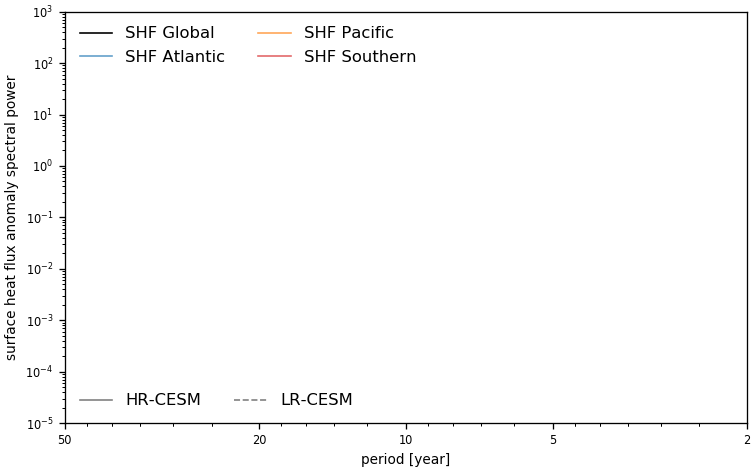

In [21]:
plt.figure(figsize=(6.4,4), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        shift= [1,1/10,1/5000,1/20000][j]
        l, = plt.plot(freq, spec*shift,
                      label=f'SHF {basin}',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = plt.plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  plt.arrow(1/41+(1/40.3-1/41)*(2-j), spec[6], 0, -(spec[6]-spec[6]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)
l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=2)
plt.gca().add_artist(l1)
l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

plt.xlim(1/50,1/2)
plt.xlabel(r'period [year]')
plt.ylabel('surface heat flux anomaly spectral power')
# plt.semilogx()
xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)
plt.ylim((1e-5,1e3))
# plt.savefig(f'{path_results}/MV-paper/SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig6.eps')

(1e-05, 1000.0)

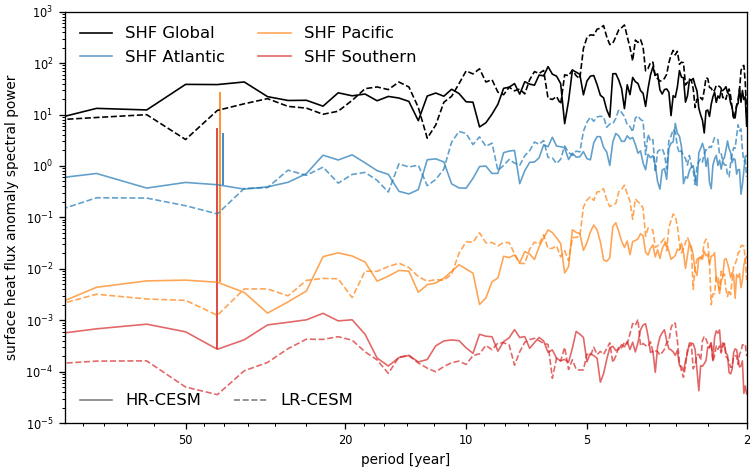

In [22]:
plt.figure(figsize=(6.4,4), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        shift= [1,1/10,1/5000,1/20000][j]
        l, = plt.plot(freq, spec*shift,
                      label=f'SHF {basin}',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = plt.plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  plt.arrow(1/41+(1/40.3-1/41)*(2-j), spec[6], 0, -(spec[6]-spec[6]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)
l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=2)
plt.gca().add_artist(l1)
l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

plt.xlim(1/100,1/2)
plt.xlabel(r'period [year]')
plt.ylabel('surface heat flux anomaly spectral power')
# plt.semilogx()
xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)
plt.ylim((1e-5,1e3))
# plt.savefig(f'{path_results}/MV-paper/SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig6.eps')

In [23]:
RMASK_low = xr.open_dataarray(file_RMASK_ocn_low)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


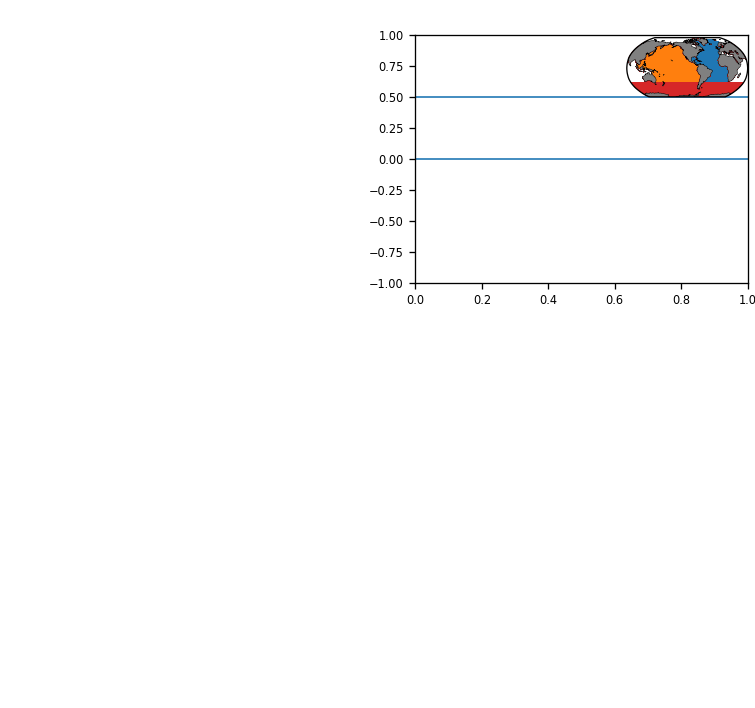

In [24]:
cmap = matplotlib.colors.ListedColormap(['C3', 'C1','w', 'C0', 'w', 'C0','w'])
boundaries = [.5, 1.5, 2.5, 5.5, 6.5, 7.5, 9.5, 15]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
f = plt.figure(figsize=(6.4,6), constrained_layout=True)
ax1 = f.add_axes([.55,.6,.44,.35])
ax1.set_ylim((-1,1))
ax1.axhline(0)
ax1.axhline(0.5)
ax2 = f.add_axes([.83,.86,.16,.09], projection=ccrs.Robinson(central_longitude=250))
lats, lons = RMASK_low.TLAT, RMASK_low.TLONG

# for i in [1,2,[6,8,9]]:
ax2.pcolormesh(lons, lats, RMASK_low,
                    cmap=cmap, norm=norm, vmin=.5, vmax=15,
                    transform=ccrs.PlateCarree(),
                    )
ax2.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k', facecolor='grey', linewidth=.3)

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The Po

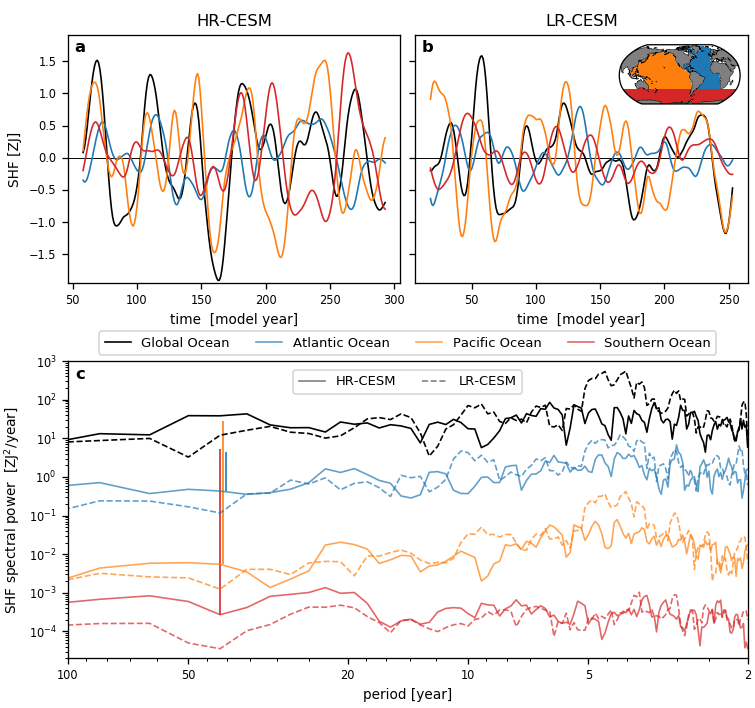

In [25]:
f = plt.figure(figsize=(6.4,6), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

ax0 = f.add_axes([.09,.6,.44,.35])
ax0.set_title('HR-CESM')
ax0.set_ylabel('SHF [ZJ]')
ax0.set_xlabel('time  [model year]')

ax1 = f.add_axes([.55,.6,.44,.35])
ax1.set_title('LR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])

for i, ax in enumerate([ax0, ax1]):
    ax.set_ylim((-1.95,1.9))
    ax.axhline(0, c='k', lw=.5)

    ts = [SHF_ctrl,SHF_lc1][i]
    time = [np.arange(51,301), np.arange(11,261)][i]
    ax.axhline(0, c='k', lw=.5)
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        # ts__ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))/1e21
        ts_ = lowpass((ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21, 13)
        ax.plot(time[7:-7], ts_[7:-7], c=c)
    ax.text(.02,.98, ['a','b'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        

cmap = matplotlib.colors.ListedColormap(['w', 'C3', 'C1', 'w', 'C0', 'w', 'C0', 'w'])
boundaries = [-15,.5, 1.5, 2.5, 5.5, 6.5, 7.5, 9.5, 15]
norm = matplotlib.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
ax2 = f.add_axes([.82,.85,.16,.09], projection=ccrs.Robinson(central_longitude=250))
ax2.pcolormesh(RMASK_low.TLONG, RMASK_low.TLAT, RMASK_low,
                    cmap=cmap, norm=norm, vmin=-16, vmax=15,
                    transform=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=2, edgecolor='k', facecolor='grey', linewidth=.3)


ax = f.add_axes([.09,.07,.9,.42])
ax.text(.01,.98, 'c', transform=ax.transAxes, va='top', ha='left', weight='bold')        
h, h_ = [], []  # contain lines with labels
for i, ts in enumerate([SHF_ctrl,SHF_lc1]):
    ls = ['-', '--'][i]
    for j, basin in enumerate(['Global', 'Atlantic','Pacific', 'Southern']):
        c = ['k' ,'C0','C1','C3'][j]
        ts_ = (ts[f'{basin}_Ocean'] - xr_quadtrend(ts[f'{basin}_Ocean']))*spy/1e21
        (spec, freq, jackknife) = ATS(ts_).spectrum()
        shift= [1,1/10,1/5000,1/20000][j]
        l, = plt.plot(freq, spec*shift,
                      label=f'{basin} Ocean',
                      ls=ls, c=c, alpha=[1,.7,.7,.7][j])
        l_, = plt.plot([0,0],[0,1], ls=ls, c='grey', label=['HR-CESM','LR-CESM'][i])
        if j==0:  h_.append(l_)
        if i==0:
            h.append(l)
            if j>0:  plt.arrow(1/41+(1/40.3-1/41)*(2-j), spec[6], 0, -(spec[6]-spec[6]*shift),\
                               length_includes_head=True, width=1e-6, head_width=0, head_length=0, color=c)
l1 = plt.legend(handles=h_, bbox_to_anchor=(0.5, 0.93), loc='center', frameon=True, ncol=2, fontsize=8)
plt.gca().add_artist(l1)
l2 = plt.legend(handles=h, bbox_to_anchor=(0.5, 1.06), loc='center', ncol=4, fontsize=8)

ax.set_xlim(1/100,1/2)
ax.set_xlabel(r'period [year]')
ax.set_ylabel(r'SHF spectral power  [ZJ$^2$/year]')
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]],numticks=10)
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)
ax.set_ylim((2e-5,1e3))
# plt.savefig(f'{path_results}/MV-paper/SHF_spectra')
plt.savefig(f'{path_results}/MV-paper/Fig5.eps')

# Fig. 8: GMST / TOA spectra

In [26]:
gmst_had  = xr.open_dataarray(f'{path_prace}/GMST/GMST_dt_yrly_had.nc', decode_times=False)
gmst_had  = gmst_had.isel({'time':slice(9,158)})
gmst_ctrl = xr.open_dataset(f'{path_prace}/GMST/GMST_ctrl.nc').GMST.isel({'time':slice(50,300)})
gmst_ctrl['time'] = (gmst_ctrl.time/365).astype(dtype=int)
gmst_ctrl -= xr_quadtrend(gmst_ctrl)
gmst_lc1_ = xr.open_dataarray(f'{path_results}/GMST/GMST_monthly_lc1.nc', decode_times=False)
gmst_lc1  = gmst_lc1_.rolling(time=12).mean().isel(time=slice(11,-1,12)).isel({'time':slice(10,260)})
gmst_lc1['time'] = (gmst_lc1.time/365).astype(dtype=int)
gmst_lc1 -= xr_quadtrend(gmst_lc1)

TOA_ctrl = xr.open_dataarray(f'{path_prace}/TOA/TOM_ctrl.nc', decode_times=False).isel(time=slice(50,300))
TOA_lc1  = xr.open_dataarray(f'{path_prace}/TOA/TOM_lc1.nc' , decode_times=False).isel(time=slice(10,260))

# SHF_ctrl = xr.open_dataset(f'{path_prace}/OHC/SHF_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/OHC/SHF_lc1.nc' , decode_times=False).isel(time=slice(10,260))
# SHF_ctrl = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_ctrl.nc', decode_times=False).isel(time=slice(50,300))
# SHF_lc1  = xr.open_dataset(f'{path_prace}/SHF/SHF_yearly_from_monthly_lc1.nc' , decode_times=False).isel(time=slice(10,260))

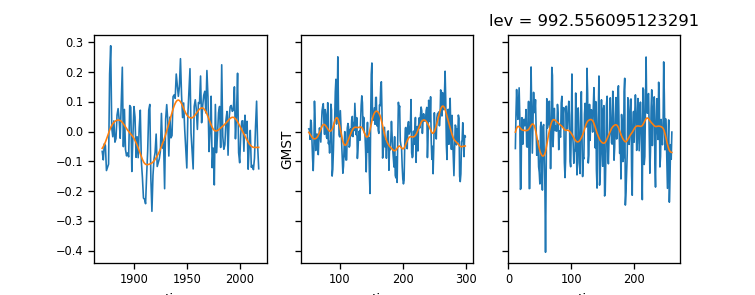

In [27]:
f, ax = plt.subplots(1,3, figsize=(6.4,2.5), sharey=True)
gmst_had.plot(ax=ax[0])
gmst_ctrl.plot(ax=ax[1])
gmst_lc1 .plot(ax=ax[2])
lowpass(gmst_had ,13).plot(ax=ax[0])
lowpass(gmst_ctrl,13).plot(ax=ax[1])
lowpass(gmst_lc1 ,13).plot(ax=ax[2])

[Text(0, 0, '50'),
 Text(0, 0, '20'),
 Text(0, 0, '10'),
 Text(0, 0, '5'),
 Text(0, 0, '2')]

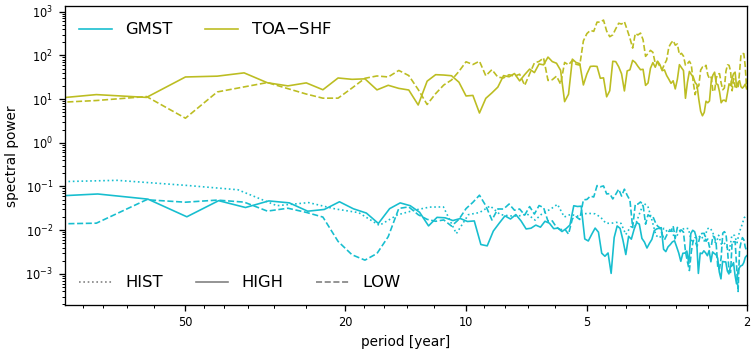

In [28]:
plt.figure(figsize=(6.4,3), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

h, h_ = [], []
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    ls = [':','-','--'][i]
    (spec, freq, jackknife) = ATS(gmst).spectrum()
#     l_, = plt.plot([0,0], [0,0], c='k', ls=ls, label=['HIST', 'HIGH', 'LOW'][i])
#     h_.append(l_)
    l, = plt.plot(freq, spec, label='GMST', c='C9', ls=ls)
    l_, = plt.plot([0,0],[0,1], ls=ls, c='grey', label=['HIST','HIGH','LOW'][i])
    h_.append(l_)
    
    if i==1: h.append(l)
l1 = plt.legend(handles=h_, bbox_to_anchor=(.3, .75), loc='center left', frameon=False)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    (spec, freq, jackknife) = ATS(div).spectrum()
    l, = plt.plot(freq, spec, label=r'TOA$-$SHF', c='C8', ls=ls)
    if i==0: h.append(l)
l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=3)
plt.gca().add_artist(l1)
l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

plt.xlim(1/100,1/2)
plt.xlabel('period [year]')
plt.ylabel(r'spectral power')
# plt.semilogx()

xticks = [50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)

# plt.savefig(f'{path_results}/MV-paper/GMST_TOA-SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig5.eps')

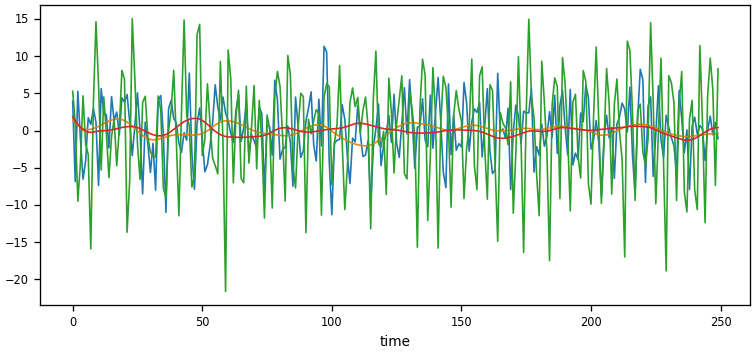

In [29]:
plt.figure(figsize=(6.4,3), constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    div.plot()
    lowpass(div,13).plot()
# l1 = plt.legend(handles=h_, loc='lower left', frameon=False, ncol=3)
# plt.gca().add_artist(l1)
# l2 = plt.legend(handles=h, loc='upper left', frameon=False, ncol=2)

# plt.xlim(1/100,1/2)
# plt.xlabel('period [year]')
# plt.ylabel(r'spectral power')
# # plt.semilogx()

# xticks = [50,20,10,5,2]
# locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
# plt.gca().set_yscale('log', basey=10)
# plt.gca().set_xscale('log', basex=10)
# plt.gca().xaxis.set_minor_locator(locmin)
# plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# plt.gca().set_xticks([1/x for x in xticks])
# plt.gca().set_xticklabels(xticks)

# plt.savefig(f'{path_results}/MV-paper/GMST_TOA-SHF_spectra')
# plt.savefig(f'{path_results}/MV-paper/Fig5.eps')

/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/ajueling/.conda/envs/CESM/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


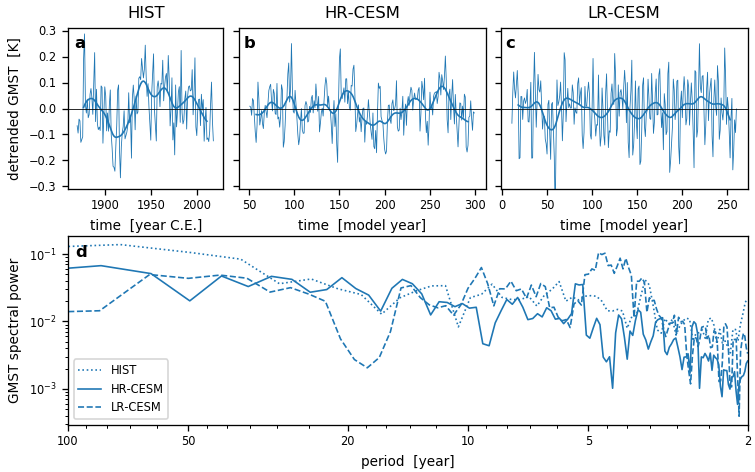

In [30]:
f = plt.figure(figsize=(6.4, 4), constrained_layout=True)

ax0 = f.add_axes([.09,.6,17/71*.86,.34])
ax0.set_title('HIST')
ax0.set_ylabel('detrended GMST  [K]')
ax0.set_xlabel('time  [year C.E.]')
ax0.set_xlim((1860,2029))
ax0.plot(gmst_had.time, gmst_had.values, lw=.5, c='C0')
ax0.plot(gmst_had.time[7:-7], lowpass(gmst_had,13)[7:-7], c='C0')

ax1 = f.add_axes([17/71*.86+.11,.6,27/71*.86,.34])
ax1.set_title('HR-CESM')
ax1.set_xlabel('time  [model year]')
ax1.set_yticklabels([])
ax1.plot(gmst_ctrl.time, gmst_ctrl.values, lw=.5, c='C0')
ax1.plot(gmst_ctrl.time[7:-7], lowpass(gmst_ctrl,13)[7:-7], c='C0')

ax2 = f.add_axes([44/71*.86+.13,.6,27/71*.86,.34])
ax2.set_title('LR-CESM')
ax2.set_xlabel('time  [model year]')
ax2.set_yticklabels([])
ax2.plot(gmst_lc1.time, gmst_lc1.values, lw=.5, c='C0')
ax2.plot(gmst_lc1.time[7:-7], lowpass(gmst_lc1,13)[7:-7], c='C0')

for i, ax in enumerate([ax0,ax1,ax2]):
    ax.axhline(0,c='k', lw=.5)
    ax.set_ylim((-.31,.31))
    ax.text([.04,.02,.02][i],.95, ['a','b','c'][i], transform=ax.transAxes, va='top', ha='left', weight='bold')        


ax = f.add_axes([.09,.1,.90,.4])
ax.text(.01,.95, 'd', transform=ax.transAxes, va='top', ha='left', weight='bold')        
for i, gmst in enumerate([gmst_had, gmst_ctrl, gmst_lc1]):
    ls = [':','-','--'][i]
    (spec, freq, jackknife) = ATS(gmst).spectrum()
    l, = ax.plot(freq, spec, label=['HIST','HR-CESM','LR-CESM'][i], c='C0', ls=ls)
ax.legend(fontsize=7, loc='lower left')

ax.set_xlabel('period  [year]')
ax.set_ylabel(r'GMST spectral power')
ax.set_xlim(1/100,1/2)
xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
ax.set_yscale('log', basey=10)
ax.set_xscale('log', basex=10)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1/x for x in xticks])
ax.set_xticklabels(xticks)

# plt.savefig(f'{path_results}/MV-paper/GMST_spectra')
plt.savefig(f'{path_results}/MV-paper/Fig8.eps')

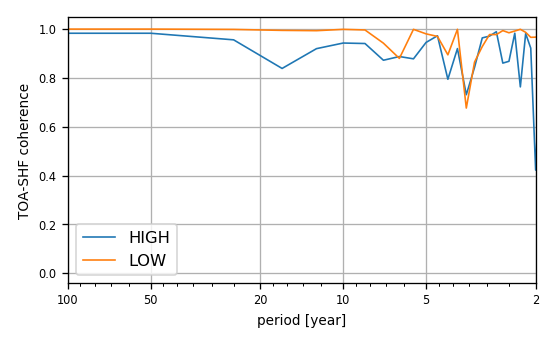

In [31]:
for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    # for n in [25,50,70,100,125]:
        # plt.cohere(toa, shf, NFFT=n,  c=f'C{i}') #label=['HIGH', 'LOW'][i],
    plt.cohere(toa, shf, NFFT=100,  c=f'C{i}', label=['HIGH', 'LOW'][i])
plt.legend()
# plt.gca().semilogx()

plt.xlim(1/100,1/2)
plt.xlabel('period [year]')
plt.ylabel(r'TOA-SHF coherence')
# plt.semilogx()

xticks = [100,50,20,10,5,2]
locmin = matplotlib.ticker.LogLocator(base=10, subs=[1/x for x in [90,80,70,60,45,40,35,30,25,18,16,14,12,9,8,7,6,4.5,4,3.5,3,2.5]])
# plt.gca().set_yscale('log', basey=10)
plt.gca().set_xscale('log', basex=10)
plt.gca().xaxis.set_minor_locator(locmin)
plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
plt.gca().set_xticks([1/x for x in xticks])
plt.gca().set_xticklabels(xticks)
plt.tight_layout()

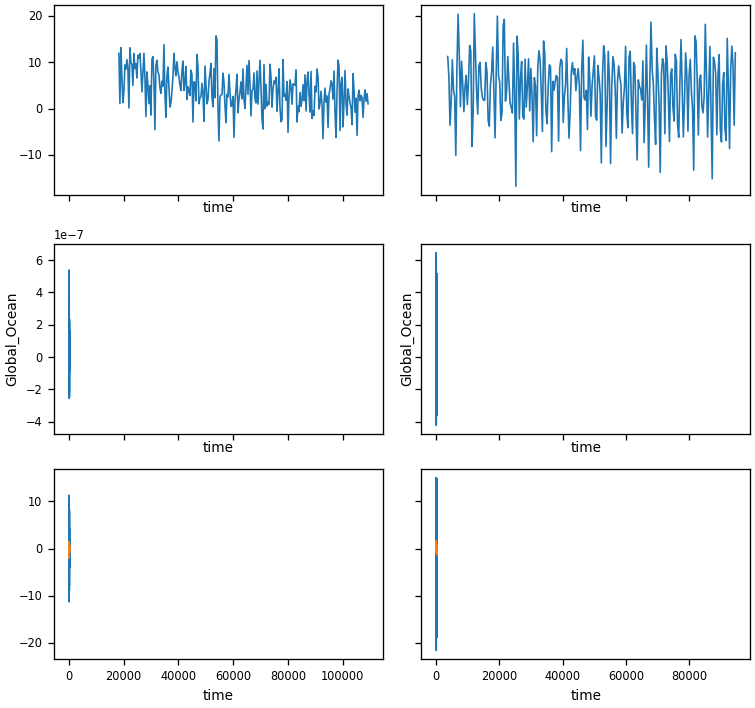

In [32]:
f, ax = plt.subplots(3,2, figsize=(6.4,6), sharey='row', sharex='col', constrained_layout=True)
# plt.gca().tick_params(labelsize=14)

for i in range(2):
    ls = ['-','--'][i]
    toa = [TOA_ctrl, TOA_lc1][i]*spy/1e21
    shf  = [SHF_ctrl, SHF_lc1][i]['Global_Ocean']/1e21
    toa.plot(ax=ax[0,i])
    shf.plot(ax=ax[1,i])
    div = toa.assign_coords(time=shf.time.values)-shf
    div -= xr_quadtrend(div)
    div.plot(ax=ax[2,i])
    lowpass(div,13)[7:-7].plot(ax=ax[2,i])

In [33]:
from paths import CESM_filename
from xr_DataArrays import xr_AREA

AttributeError: 'Dataset' object has no attribute 'FSNT'

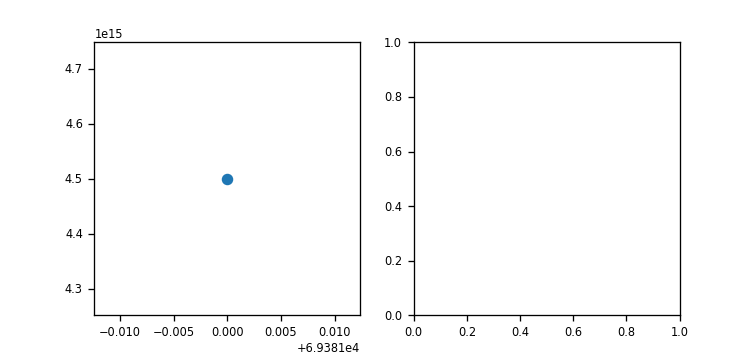

In [34]:
%%time
f, ax = plt.subplots(1,2, figsize=(6.4,3))
for i, run in enumerate(['ctrl','lc1']):
    AREA_ocn = xr_AREA(domain=['ocn','ocn_low'][i])
    AREA_atm = xr_AREA(domain=['atm','atm_f09'][i])
    for y in range(1):
        y_ = y+[190, 195][i]
        for m in notebook.tqdm(range(12)):
            do = xr.open_dataset(CESM_filename(domain='ocn', run=run, y=y_, m=m+1), decode_times=False)
            da = xr.open_dataset(CESM_filename(domain='ocn', run=run, y=y_, m=m+1), decode_times=False)
            shf = (do.SHF*AREA_ocn).sum()
            ax[0].scatter(da.time, shf.values)
            toa = ((da.FSNT-da.FLNT)*AREA_atm).sum()
            ax[1].scatter(da.time, toa.values)



# Table 2: variances for different bandpass filters

How much area/volume do the major ocean basins represent?

In [35]:
from xr_DataArrays import xr_DZ, xr_AREA
from paths import file_RMASK_ocn
from regions import regions_dict
DZT = xr_DZ('ocn')
AREA = xr_AREA('ocn')
MASK = xr.open_dataarray(file_RMASK_ocn)

In [36]:
total_area = AREA.where(MASK>0).sum(dim=['nlat','nlon'],skipna=True).values
total_volume = (DZT*AREA.where(MASK>0)).sum(dim=['z_t','nlat','nlon'],skipna=True).values
print(f'total area {total_area} volume {total_volume}')
for i in [1,2,6]:
    area = AREA.where(MASK==i).sum(dim=['nlat','nlon'],skipna=True).values
    volume = (DZT*AREA.where(MASK==i)).sum(dim=['z_t','nlat','nlon'],skipna=True).values
    print(f'{regions_dict[i]:15}: area {area/total_area*100:2.0f}%; volume {volume/total_volume*100:2.0f}%')
    

total area 359737888768820.5 volume 1.3302928999664492e+18
Southern_Ocean : area 26%; volume 27%
Pacific_Ocean  : area 38%; volume 41%
Atlantic_Ocean : area 18%; volume 18%
